In [1]:
%reload_ext autotime
import rasterio
import requests
from rasterio.features import shapes, sieve, rasterize
from rasterio.plot import show
import geopandas as gpd
import os
import numpy as np
from tqdm.auto import tqdm
from shapely.geometry import box, shape
from rasterio.mask import mask
from matplotlib import pyplot as plt

In [2]:
if not os.path.isfile("old.tif"):
    with open("old.tif", "wb") as f:
        response = requests.get("https://nz-elevation.s3.ap-southeast-2.amazonaws.com/gisborne/gisborne_2018-2020/dem_1m/2193/BD44_10000_0503.tiff")
        f.write(response.content)
    with open("new.tif", "wb") as f:
        response = requests.get("https://nz-elevation.s3.ap-southeast-2.amazonaws.com/gisborne/gisborne_2023/dem_1m/2193/BD44_10000_0503.tiff")
        f.write(response.content)
old = rasterio.open("old.tif")
new = rasterio.open("new.tif")

In [3]:
new.crs, old.crs

(CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]'),
 CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9

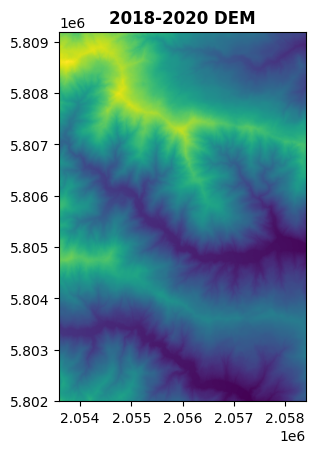

<Axes: title={'center': '2018-2020 DEM'}>

In [4]:
show(old, title="2018-2020 DEM")

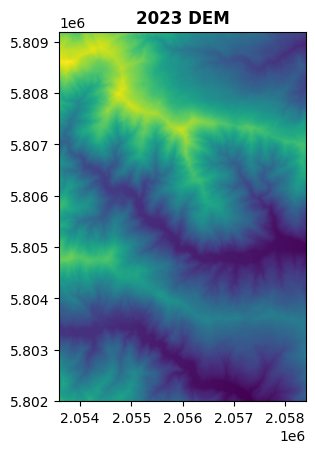

<Axes: title={'center': '2023 DEM'}>

In [5]:
show(new, title="2023 DEM")

(7200, 4800)


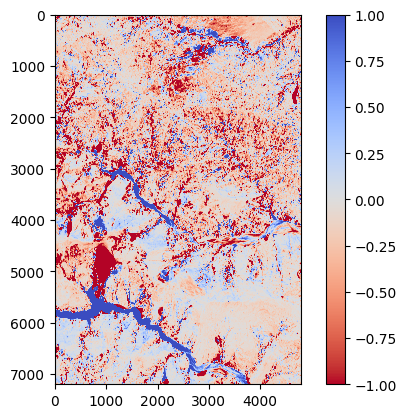

In [6]:
diff = new.read(1) - old.read(1)
print(diff.shape)
plt.imshow(diff, cmap="coolwarm_r", vmin=-1, vmax=1)
plt.colorbar()

Text(0.5, 1.0, 'Histogram of elevation differences')

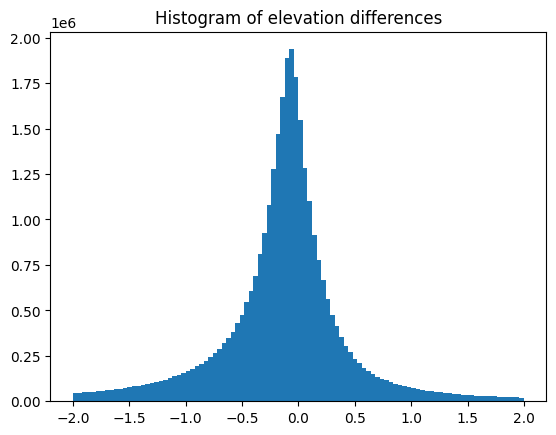

In [7]:
_ = plt.hist(diff.flatten(), bins=100, range=(-2, 2))
plt.title("Histogram of elevation differences")

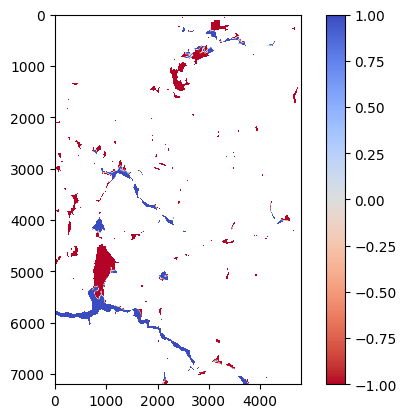

In [8]:
result = diff.round().clip(min=-1, max=1).astype(np.int16)
result = sieve(result, 4000)
result = np.where(result != 0, result, np.nan)
plt.imshow(result, cmap="coolwarm_r")
plt.colorbar()

<Axes: >

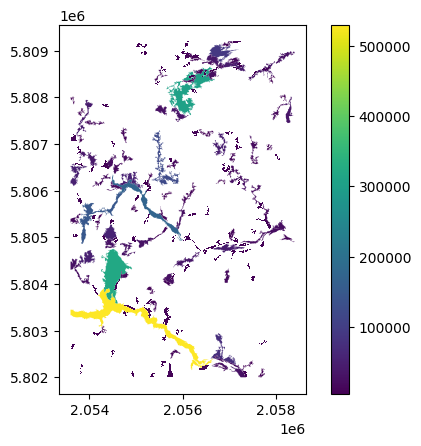

In [9]:
areas = gpd.GeoDataFrame(geometry=[shape(s) for s, v in shapes(result, transform=new.transform) if not np.isnan(v)])
areas["area"] = areas.area
areas.sort_values("area", ascending=False, inplace=True)
areas.plot("area", legend=True)

In [10]:
largest_area = areas.head(1)
largest_area

,geometry,area
176,"POLYGON ((2054419.000 5803910.000, 2054419.000...",530308.0


[5290    0] [7044 3057]


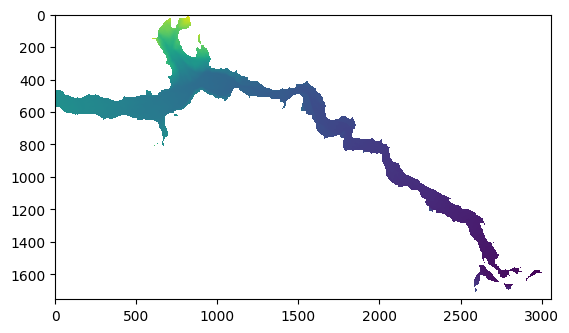

<Axes: >

In [11]:
masked_old, transform = mask(old, largest_area.geometry, nodata=np.nan)
nonan = np.argwhere(~np.isnan(masked_old[0]))
top_left = nonan.min(axis=0)
bottom_right = nonan.max(axis=0)
print(top_left, bottom_right)
masked_old = masked_old[0][top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
show(masked_old)

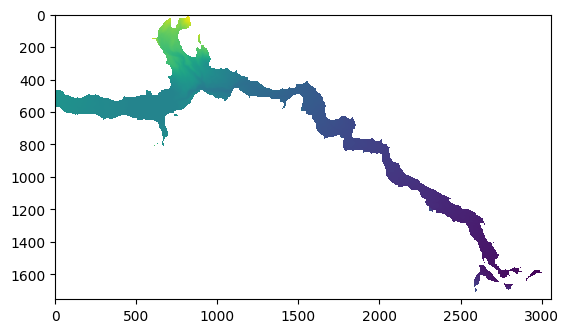

<Axes: >

In [12]:
masked_new, transform = mask(new, largest_area.geometry, nodata=np.nan)
masked_new = masked_new[0][top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
show(masked_new)

In [13]:
np.nanmin(masked_old), np.nanmax(masked_old), np.nanmean(masked_old), np.nanmedian(masked_old), np.nanstd(masked_old)

(264.148, 520.245, 347.9752, 350.69598, 49.78903)

In [14]:
masked_new.shape

(1755, 3058)

In [15]:
diff.shape

(7200, 4800)

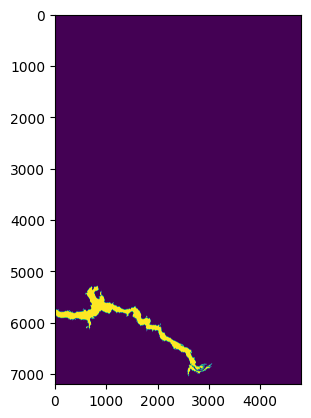

In [16]:
raster = rasterize(largest_area.geometry, out_shape=result.shape, transform=new.transform)
plt.imshow(raster)

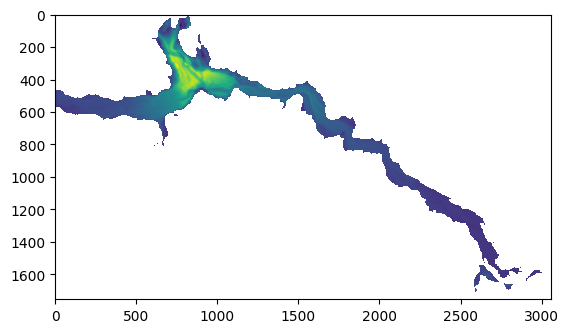

<Axes: >

In [17]:
masked_diff = np.where(raster, diff, np.nan)
masked_diff = masked_diff[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
show(masked_diff)

In [18]:
np.nanmin(masked_diff), np.nanmax(masked_diff), np.nanmean(masked_diff), np.nanmedian(masked_diff), np.nanstd(masked_diff)

(-6.8740234, 43.521973, 8.370939, 4.911972, 9.06017)

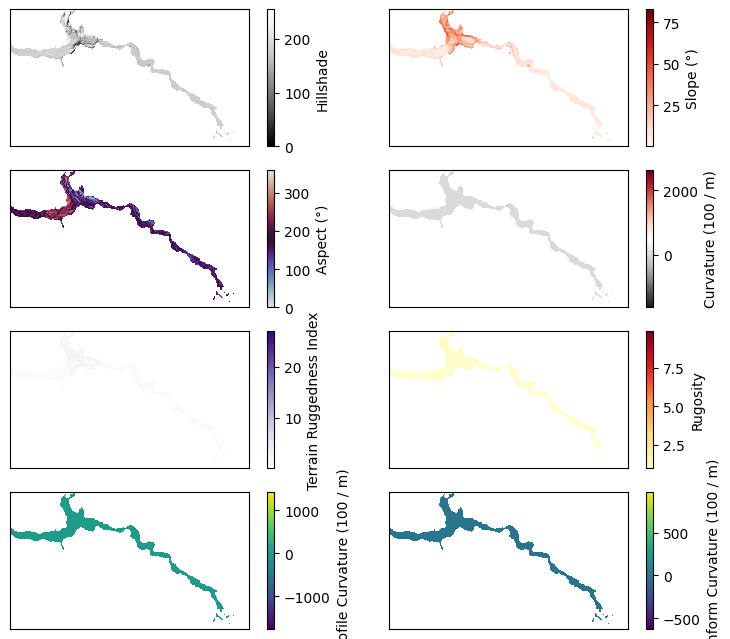

In [19]:
import xdem

attributes = xdem.terrain.get_terrain_attribute(
    masked_diff.data,
    resolution=old.res,
    attribute=["hillshade", "slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity", "profile_curvature", "planform_curvature"],
)

plt.figure(figsize=(8, 6.5))

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd", "viridis", "viridis"]
labels = ["Hillshade", "Slope (°)", "Aspect (°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity", "Profile Curvature (100 / m)", "Planform Curvature (100 / m)"]

for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()